In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
import random
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

In [38]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [42]:
class PatchDataset(Dataset):
    def __init__(self, X, y, augment=False, minority_class=1):
        self.X = X
        self.y = y
        self.augment = augment
        self.minority_class = minority_class
        # Define transforms
        self.common_transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.minority_transform = minority_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=1.0),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5)
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (256,256,8)
        y = self.y[idx]

        if self.augment:
            if y == self.minority_class:
                x = self.minority_transform(image=x)["image"]

        # Convert to tensor and move channels first (C,H,W)
        x = torch.from_numpy(x).permute(2, 0, 1)  # (8,256,256)

        return x.float(), torch.tensor(y, dtype=torch.long)

In [21]:
class CNN(nn.Module):
    def __init__(self, num_classes=2, in_channels=8):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # global pooling
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [22]:
# Load patches
patches = np.load("/home/ubuntu/mucilage_pipeline/patches.npy")  # shape (1643, 256, 256, 8)

# Load labels CSV
labels_df = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected.csv")
labels_df = labels_df[~labels_df['label'].isin(['algae'])]

# Map string labels to integers
label_mapping = {
    "clean_water": 0,
    "mucilage": 1
}
labels_df["label_id"] = labels_df["label"].map(label_mapping)

# Subset patches based on indices in CSV
selected_indices = labels_df["index"].values
X = patches[selected_indices]   # shape (N, 256,256,8)
y = labels_df["label_id"].values  # shape (N,)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (809, 256, 256, 8)
y shape: (809,)


In [23]:
# Replace NaNs and Infs with 0
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Add normalization
# mean = X.mean(axis=(0,1,2))   # mean per band
# std  = X.std(axis=(0,1,2))    # std per band
# X = (X - mean) / std

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

In [15]:
# Count samples for each class
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array([0, 1]), array([488,  78]))
(array([0, 1]), array([209,  34]))


In [43]:
train_dataset = PatchDataset(X_train, y_train, augment=True)
val_dataset   = PatchDataset(X_val, y_val, augment=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(np.unique(y_train))
model = CNN(num_classes=num_classes, in_channels=8).to(device)

#weights = torch.tensor([1.0, 4.0])  # inverse of class frequency
criterion = nn.CrossEntropyLoss() #weight=weights.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)



num_epochs=10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Train
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data, targets = data.to(device), targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # accumulate stats
        batch_size = targets.size(0)
        running_loss_train += loss.item() * batch_size

        _, preds = torch.max(scores, 1)
        correct_train += (preds == targets).sum().item()
        total_train += batch_size

    # Evaluate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                batch_size = targets.size(0)

                scores = model(data)
                loss = criterion(scores, targets)

                running_val_loss += loss.item() * batch_size
                _, preds = torch.max(scores, 1)
                correct_val += (preds == targets).sum().item()
                total_val += batch_size

    # Compute epoch-level metrics
    train_epoch_loss = running_loss_train / total_train
    train_losses.append(train_epoch_loss)
    train_epoch_acc = correct_train / total_train
    print(f"Train Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_acc:.4f}")

    val_epoch_loss = running_val_loss / total_val
    valid_losses.append(val_epoch_loss)
    val_epoch_acc = correct_val / total_val
    print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

Epoch [1/10]


  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [01:02<00:00,  1.75s/it]


Train Loss: 0.3735, Accuracy: 0.8710
Validation Loss: 0.4292, Accuracy: 0.8601
Epoch [2/10]


100%|██████████| 36/36 [01:03<00:00,  1.75s/it]


Train Loss: 0.3263, Accuracy: 0.8993
Validation Loss: 0.4150, Accuracy: 0.8601
Epoch [3/10]


100%|██████████| 36/36 [01:04<00:00,  1.79s/it]


Train Loss: 0.3255, Accuracy: 0.8922
Validation Loss: 0.4115, Accuracy: 0.8601
Epoch [4/10]


100%|██████████| 36/36 [01:01<00:00,  1.71s/it]


Train Loss: 0.3340, Accuracy: 0.8905
Validation Loss: 0.4187, Accuracy: 0.8601
Epoch [5/10]


100%|██████████| 36/36 [01:01<00:00,  1.71s/it]


Train Loss: 0.3229, Accuracy: 0.8852
Validation Loss: 0.4245, Accuracy: 0.8601
Epoch [6/10]


100%|██████████| 36/36 [01:03<00:00,  1.77s/it]


Train Loss: 0.3223, Accuracy: 0.8781
Validation Loss: 0.4345, Accuracy: 0.8601
Epoch [7/10]


100%|██████████| 36/36 [01:08<00:00,  1.90s/it]


Train Loss: 0.2956, Accuracy: 0.8958
Validation Loss: 0.4692, Accuracy: 0.8601
Epoch [8/10]


100%|██████████| 36/36 [01:05<00:00,  1.81s/it]


Train Loss: 0.3179, Accuracy: 0.8887
Validation Loss: 0.4218, Accuracy: 0.8601
Epoch [9/10]


100%|██████████| 36/36 [01:03<00:00,  1.77s/it]


Train Loss: 0.3082, Accuracy: 0.8869
Validation Loss: 0.4625, Accuracy: 0.8601
Epoch [10/10]


100%|██████████| 36/36 [01:03<00:00,  1.78s/it]


Train Loss: 0.3044, Accuracy: 0.8922
Validation Loss: 0.6832, Accuracy: 0.8601


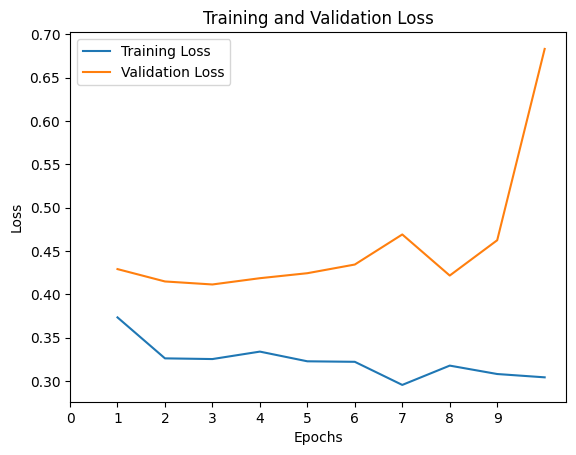

In [45]:
epochs = range(1, num_epochs + 1)

# Plot and label the training and validation loss values
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, len(epochs), 1))
 
# Display the plot
plt.legend(loc='best')
plt.show()